In [1279]:
import requests
import pandas as pd
import json
import io
import itertools
import datetime
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
import statistics

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC

In [437]:
full_game_logs_df = pd.read_csv('data-full/2021_22_NBA_REG_GAME_LOGS_COMBINED.csv')

In [438]:
full_game_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
0,2021-22,203497,Rudy Gobert,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,198,11,21,19.0,0.0,0.169333,0.200000,24,16,0
1,2021-22,201144,Mike Conley,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,146,6,6,4.0,0.0,0.079500,0.206000,64,5,0
2,2021-22,203903,Jordan Clarkson,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,167,1,5,7.0,0.0,0.139000,0.223667,7,70,0
3,2021-22,1628384,O.G. Anunoby,1610612761,TOR,Toronto Raptors,22101226,2022-04-10T00:00:00,TOR @ NYK,L,...,0,0,0,0.0,0.0,0.000000,0.000000,22,9,0
4,2021-22,1627751,Jakob Poeltl,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,116,7,8,11.0,1.0,0.157500,0.236000,12,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,2021-22,1629673,Jordan Poole,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,2,598,0
6695,2021-22,203110,Draymond Green,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,45,158,0
6696,2021-22,203952,Andrew Wiggins,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,13,158,0
6697,2021-22,201988,Patty Mills,1610612751,BKN,Brooklyn Nets,22100001,2021-10-19T00:00:00,BKN @ MIL,L,...,0,0,0,0.0,0.0,0.000000,0.000000,10,1739,0


In [439]:
full_game_logs_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'PTS', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [440]:
# get subset of numerical game stats
# remove FG3M, FTM, FGM as they were used to calculate FGM_PAINT, FGM_2PT_MR, PW_FGM_PAINT, PW_FGM_2PT_MR
# remove PTS, PTS_PAINT, PCT_PTS_2PT_MR as FGA, FTA shot attempts better encapsulate court activity
game_logs_subset = ['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'USG_PCT', 'PIE',
       'POSS','AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME']

In [441]:
game_logs_data = full_game_logs_df[game_logs_subset]

In [442]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [443]:
game_logs_data.corr()

,MIN,FGA,FG3A,FTA,OREB,DREB,AST,TOV,STL,BLK,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
MIN,1.000000,0.610269,0.310733,0.358177,0.100946,0.297301,0.376485,0.315127,0.181537,0.087985,...,0.203781,0.084240,0.271175,0.216866,0.239746,0.201523,0.258229,0.092887,-0.015338,-0.089675
FGA,0.610269,1.000000,0.505073,0.422355,0.072772,0.215734,0.345942,0.330832,0.130957,0.004164,...,0.150525,0.046865,0.369135,0.296970,0.364597,0.264780,0.492593,0.061965,-0.046881,-0.019820
FG3A,0.310733,0.505073,1.000000,0.010978,-0.288831,-0.152811,0.163464,0.107647,0.066695,-0.163635,...,0.051319,-0.084382,-0.046528,-0.187515,0.050908,-0.072451,0.174192,-0.027552,0.032124,-0.024610
FTA,0.358177,0.422355,0.010978,1.000000,0.142941,0.279077,0.220017,0.279826,0.076876,0.109883,...,0.083285,0.072690,0.435945,0.324182,0.217503,0.304545,0.352777,0.110467,-0.077391,-0.009327
OREB,0.100946,0.072772,-0.288831,0.142941,1.000000,0.322539,-0.083436,0.030518,-0.001930,0.260457,...,0.005531,0.135115,0.123283,0.261434,-0.100004,0.178095,-0.021697,-0.000515,-0.030197,-0.018617
DREB,0.297301,0.215734,-0.152811,0.279077,0.322539,1.000000,0.098126,0.204516,0.037659,0.270461,...,0.051948,0.142135,0.269493,0.321427,0.055811,0.316251,0.156269,0.081285,-0.022651,-0.034855
AST,0.376485,0.345942,0.163464,0.220017,-0.083436,0.098126,1.000000,0.336399,0.176647,-0.071684,...,0.102734,-0.006049,0.240481,0.129615,0.258019,0.209782,0.275259,0.164415,-0.060318,0.000642
TOV,0.315127,0.330832,0.107647,0.279826,0.030518,0.204516,0.336399,1.000000,0.089213,0.012023,...,0.081725,0.056230,0.282857,0.205551,0.188308,0.231996,0.315004,0.088995,-0.025834,-0.002490
STL,0.181537,0.130957,0.066695,0.076876,-0.001930,0.037659,0.176647,0.089213,1.000000,0.016608,...,0.015743,0.027728,0.040964,0.009703,0.038051,0.056564,0.042046,0.073806,-0.016730,-0.017448
BLK,0.087985,0.004164,-0.163635,0.109883,0.260457,0.270461,-0.071684,0.012023,0.016608,1.000000,...,-0.041186,0.075298,0.069589,0.135748,-0.063866,0.129898,-0.008605,0.088600,-0.030995,-0.011751


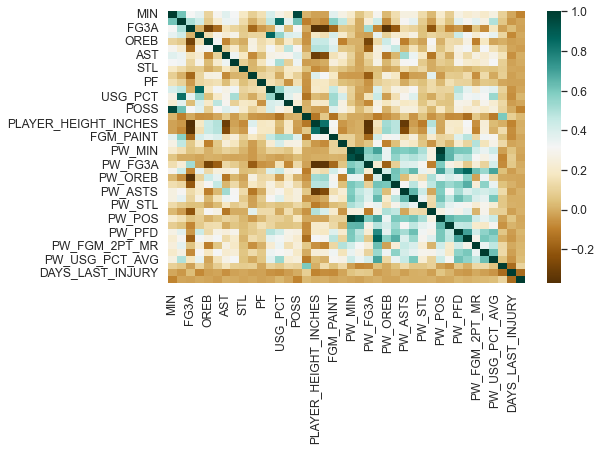

In [444]:
sns.heatmap(game_logs_data.corr(), cmap='BrBG');

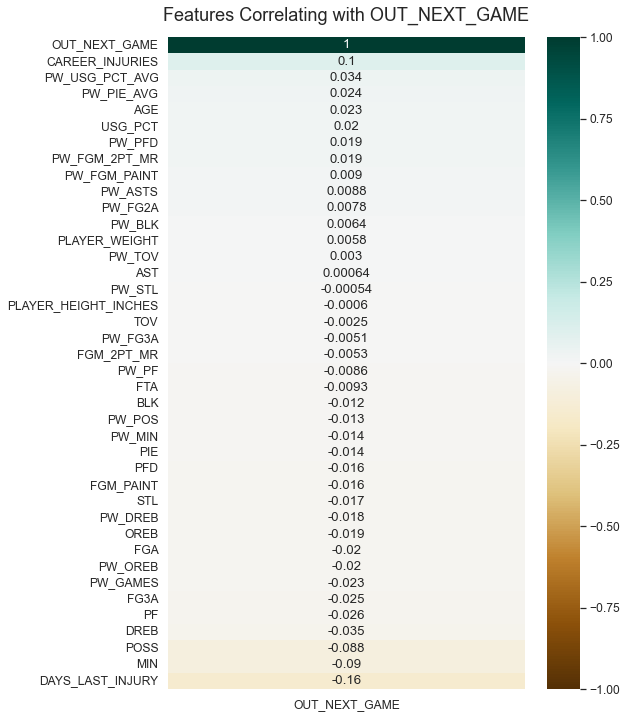

In [445]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(game_logs_data.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with OUT_NEXT_GAME', fontdict={'fontsize':18}, pad=16);

In [446]:
# do we need to standardize anything?
# do not standarize: USG_PCT, PIE, PW_PIE_AVG, PW_USG_PCT_AVG

In [447]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [13]:
# Compute basic statistics
injury_vars = ['CAREER_INJURIES', 'DAYS_LAST_INJURY', 'OUT_NEXT_GAME']
injury_stats = game_logs_data[injury_vars].describe()
print(injury_stats)

       CAREER_INJURIES  DAYS_LAST_INJURY  OUT_NEXT_GAME
count      6699.000000       6699.000000    6699.000000
mean         24.066129         91.969846       0.077176
std          18.656253        171.381759       0.266890
min           2.000000          0.000000       0.000000
25%          12.000000         14.000000       0.000000
50%          18.000000         34.000000       0.000000
75%          32.000000        160.000000       0.000000
max         117.000000       1822.000000       1.000000


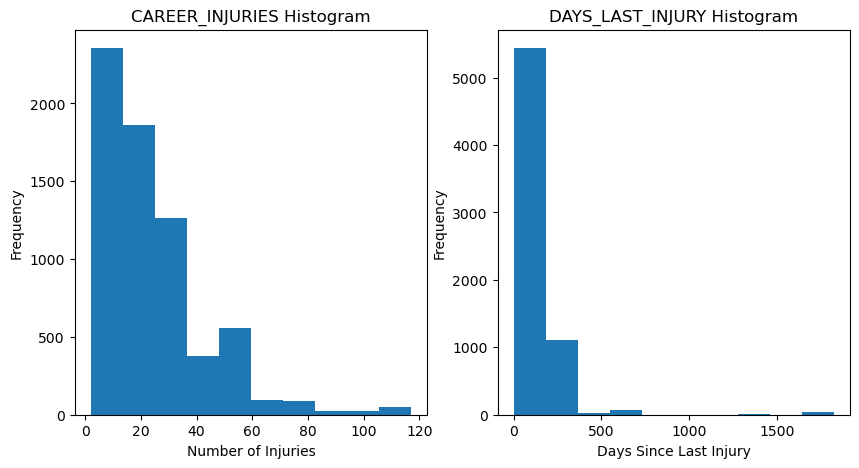

In [21]:
# Create histograms for CAREER_INJURIES and DAYS_LAST_INJURY
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(game_logs_data['CAREER_INJURIES'], bins=10)
axs[0].set_title("CAREER_INJURIES Histogram")
axs[0].set_xlabel("Number of Injuries")
axs[0].set_ylabel("Frequency")
axs[1].hist(game_logs_data['DAYS_LAST_INJURY'], bins=10)
axs[1].set_title("DAYS_LAST_INJURY Histogram")
axs[1].set_xlabel("Days Since Last Injury")
axs[1].set_ylabel("Frequency")
plt.show()

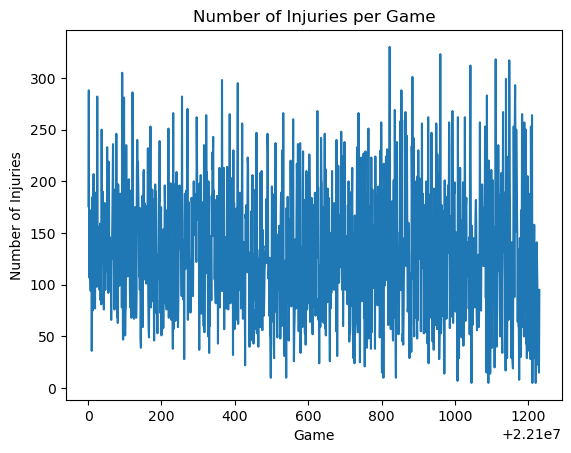

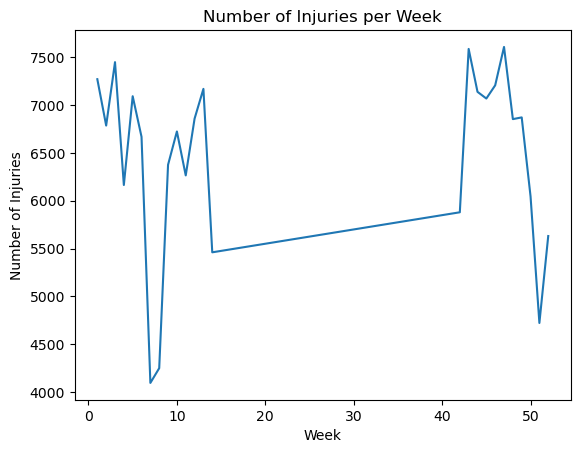

In [23]:
# Group the data by game and count the number of injuries
injuries_per_game = full_game_logs_df.groupby('GAME_ID')['CAREER_INJURIES'].sum()

# Create a line plot of injuries per game
plt.plot(injuries_per_game)
plt.title('Number of Injuries per Game')
plt.xlabel('Game')
plt.ylabel('Number of Injuries')
plt.show()

# Group the data by week and count the number of injuries
full_game_logs_df['GAME_DATE'] = pd.to_datetime(full_game_logs_df['GAME_DATE'])
full_game_logs_df['WEEK'] = full_game_logs_df['GAME_DATE'].dt.isocalendar().week
injuries_per_week = full_game_logs_df.groupby('WEEK')['CAREER_INJURIES'].sum()

# Create a line plot of injuries per week
plt.plot(injuries_per_week)
plt.title('Number of Injuries per Week')
plt.xlabel('Week')
plt.ylabel('Number of Injuries')
plt.show()

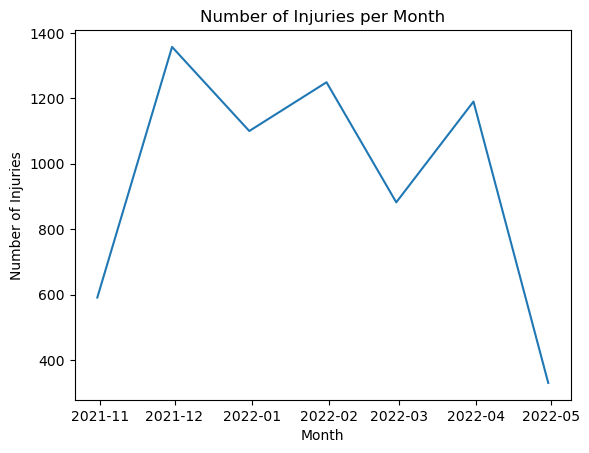

In [24]:
# Convert the date column to datetime type
full_game_logs_df['GAME_DATE'] = pd.to_datetime(full_game_logs_df['GAME_DATE'])

# Group the data by month and count the number of injuries
injuries_per_month = full_game_logs_df.groupby(pd.Grouper(key='GAME_DATE', freq='M'))['CAREER_INJURIES'].count()

# Plot the number of injuries per month
plt.plot(injuries_per_month.index, injuries_per_month.values)
plt.title('Number of Injuries per Month')
plt.xlabel('Month')
plt.ylabel('Number of Injuries')
plt.show()

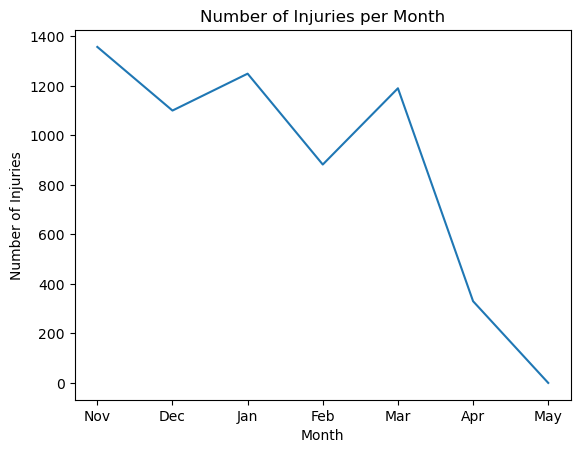

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the date column to datetime type
full_game_logs_df['GAME_DATE'] = pd.to_datetime(full_game_logs_df['GAME_DATE'])

# Define a custom sort order for the months
month_order = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
full_game_logs_df['MONTH'] = pd.Categorical(full_game_logs_df['GAME_DATE'].dt.strftime('%b'), categories=month_order, ordered=True)

# Group the data by month and count the number of injuries
injuries_per_month = full_game_logs_df.groupby('MONTH')['CAREER_INJURIES'].count()

# Plot the number of injuries per month
plt.plot(injuries_per_month.index, injuries_per_month.values)
plt.title('Number of Injuries per Month')
plt.xlabel('Month')
plt.ylabel('Number of Injuries')
plt.show()

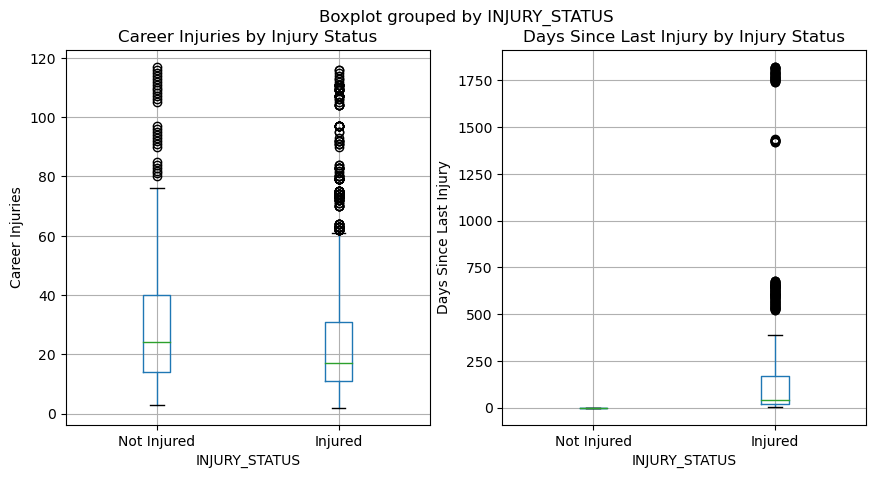

In [26]:
import matplotlib.pyplot as plt

# Create a new column indicating whether a player has missed games due to injury or not
full_game_logs_df['INJURY_STATUS'] = full_game_logs_df['OUT_NEXT_GAME'].apply(lambda x: 'Injured' if x == 1 else 'Not Injured')

# Create box plots comparing the distribution of CAREER_INJURIES and DAYS_LAST_INJURY for the two groups
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

full_game_logs_df.boxplot(column='CAREER_INJURIES', by='INJURY_STATUS', ax=axes[0])
axes[0].set_title('Career Injuries by Injury Status')
axes[0].set_ylabel('Career Injuries')
axes[0].set_xticklabels(['Not Injured', 'Injured'])

full_game_logs_df.boxplot(column='DAYS_LAST_INJURY', by='INJURY_STATUS', ax=axes[1])
axes[1].set_title('Days Since Last Injury by Injury Status')
axes[1].set_ylabel('Days Since Last Injury')
axes[1].set_xticklabels(['Not Injured', 'Injured'])

plt.show()

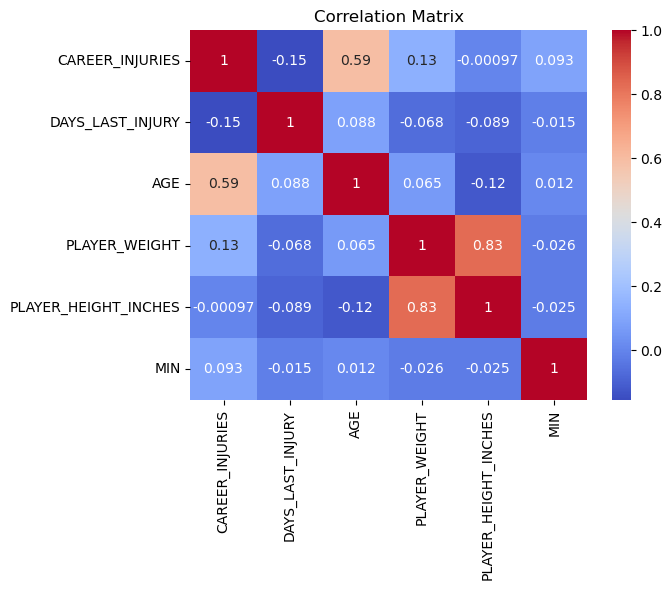

In [27]:
# Select variables related to injuries and other variables
selected_cols = ['CAREER_INJURIES', 'DAYS_LAST_INJURY', 'AGE', 'PLAYER_WEIGHT', 'PLAYER_HEIGHT_INCHES', 'MIN']

# Create a subset of the original dataframe with the selected columns
subset_df = full_game_logs_df[selected_cols]

# Compute the correlation matrix
corr_matrix = subset_df.corr()

# Plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

/Users/nadeempatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nadeempatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nadeempatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/nadeempatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1239
           1       1.00      1.00      1.00       101

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



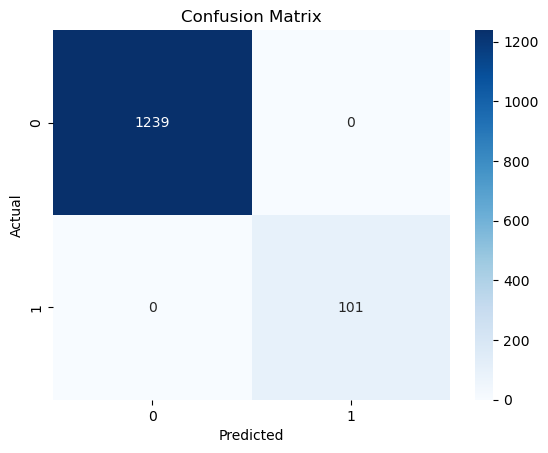

                Variable  Coefficient
41         OUT_NEXT_GAME     2.026963
39       CAREER_INJURIES     0.088798
38        PW_USG_PCT_AVG     0.030452
34                PW_PFD     0.026484
37            PW_PIE_AVG     0.019210
6                    AST     0.015007
36         PW_FGM_2PT_MR     0.013969
12               USG_PCT     0.013706
31                PW_BLK     0.013631
35          PW_FGM_PAINT     0.013268
33                 PW_PF     0.011279
29                PW_TOV     0.006097
24               PW_FG3A     0.005326
7                    TOV     0.004296
17                   AGE     0.003931
25               PW_FG2A     0.003602
1                    FGA     0.003305
28               PW_ASTS     0.002789
9                    BLK     0.001865
18  PLAYER_HEIGHT_INCHES     0.000204
4                   OREB    -0.000056
19         PLAYER_WEIGHT    -0.000269
32                PW_POS    -0.001669
15             PTS_PAINT    -0.001963
20             FGM_PAINT    -0.001963
30          

In [28]:
# Select relevant variables
predictors = ['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR',
       'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FGM_PAINT',
       'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES', 'PW_FG3A', 'PW_FG2A', 'PW_OREB',
       'PW_DREB', 'PW_ASTS', 'PW_TOV', 'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF',
       'PW_PFD', 'PW_FGM_PAINT', 'PW_FGM_2PT_MR', 'PW_PIE_AVG',
       'PW_USG_PCT_AVG', 'CAREER_INJURIES', 'DAYS_LAST_INJURY',
       'OUT_NEXT_GAME']
outcome = 'OUT_NEXT_GAME'

# Prepare the data
X = full_game_logs_df[predictors]
y = full_game_logs_df[outcome]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, class_weight='balanced')
)

# Define grid search parameters
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1],
    'logisticregression__penalty': ['l1', 'l2']
}

# Perform grid search cross-validation
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Interpret the results
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': grid.best_estimator_.named_steps['logisticregression'].coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

# Print best parameters from grid search
print('Best Parameters:', grid.best_params_)


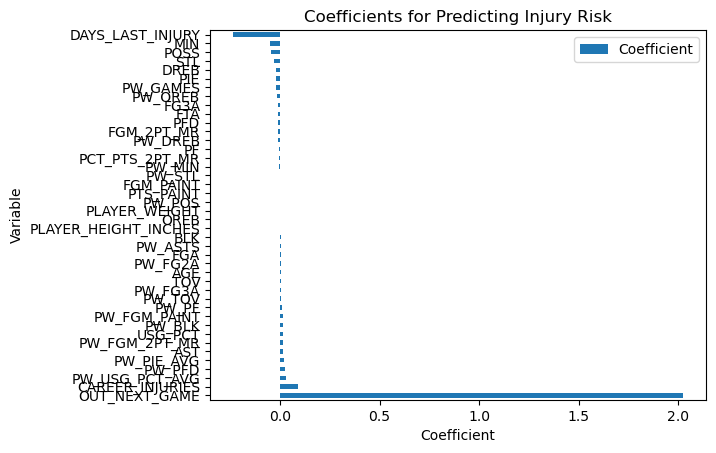

In [29]:
import matplotlib.pyplot as plt

# Plot coefficients
fig, ax = plt.subplots()
coefficients.plot(x='Variable', y='Coefficient', kind='barh', ax=ax)
ax.set_xlabel('Coefficient')
ax.set_title('Coefficients for Predicting Injury Risk')
plt.show()

NameError: name 'model' is not defined

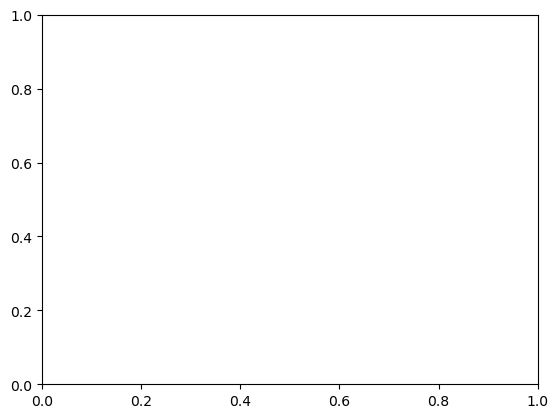

In [30]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

# Plot confusion matrix
fig, ax = plt.subplots()
plot_confusion_matrix(model, X_test, y_test, ax=ax)
ax.set_title('Confusion Matrix for Injury Risk Model')
plt.show()

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve(model, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
ax.set_title('ROC Curve for Injury Risk Model')
plt.legend()
plt.show()

In [1239]:
# dataset: all quantifiable variables
GAME_LOGS_SUBSET_X = ['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'USG_PCT', 'PIE',
       'POSS','AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY']

REMOVE_DAYS_LAST_INJURY = False;
# REMOVE_DAYS_LAST_INJURY = True;

def prep_data(game_logs_df):
    # global: GAME_LOGS_SUBSET_X
    game_logs_subset_X = GAME_LOGS_SUBSET_X.copy()

    # global: REMOVE_DAYS_LAST_INJURY
    if REMOVE_DAYS_LAST_INJURY:
        game_logs_subset_X.pop()

    game_logs_subset_X_df = game_logs_df[game_logs_subset_X]
    game_logs_subset_Y = game_logs_df['OUT_NEXT_GAME']

    return game_logs_subset_X_df, game_logs_subset_Y

In [1240]:
game_logs_subset_X_df, game_logs_subset_Y = prep_data(full_game_logs_df)

# split data train/test
X_train, X_test, Y_train, Y_test = train_test_split(game_logs_subset_X_df, 
    game_logs_subset_Y, test_size=0.2, random_state=42)

In [1241]:
# histogram of our variables
# sns.set(style='whitegrid', font_scale=1.1, rc={'figure.figsize': [30, 102]})
# X_train[X_train.columns].hist(bins=15, layout=(24, 4));

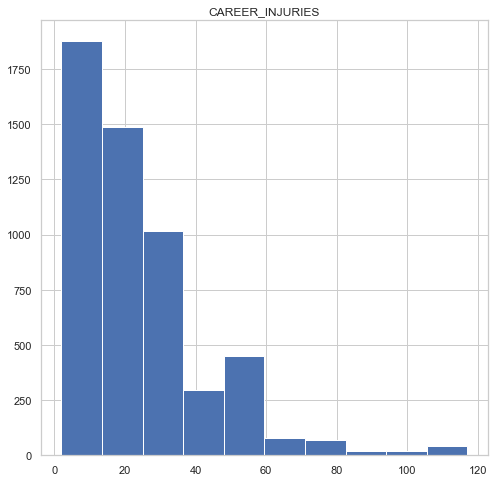

In [1242]:
# histogram of our CAREER_INJURIES
sns.set(style='whitegrid', rc={'figure.figsize': [8, 8]})
X_train[['CAREER_INJURIES']].hist(bins=10);

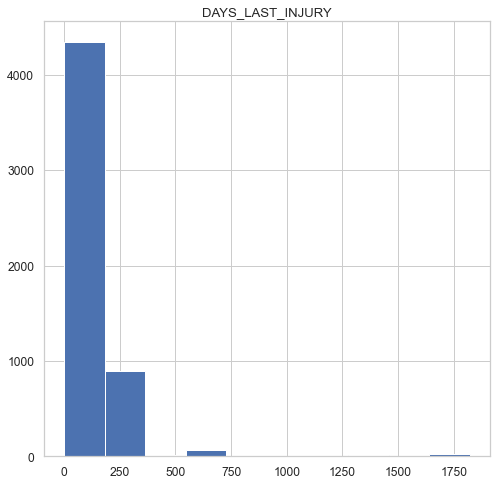

In [1243]:
# histogram of our DAYS_LAST_INJURY
sns.set(style='whitegrid', font_scale=1.1, rc={'figure.figsize': [8, 8]})
X_train[['DAYS_LAST_INJURY']].hist(bins=10);

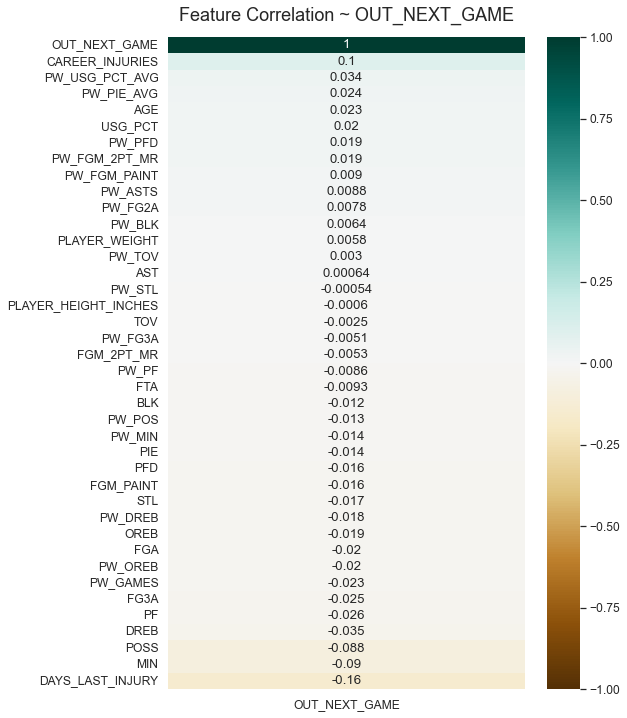

In [1244]:
game_logs_subset_X_df

# create OUT_NEXT_GAME correlation chart (after oversampling)
game_logs_subset_X_df_copy = game_logs_subset_X_df.copy()
game_logs_subset_X_df_copy.loc[:,'OUT_NEXT_GAME'] = full_game_logs_df['OUT_NEXT_GAME']
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(game_logs_subset_X_df_copy.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', 
    ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature Correlation ~ OUT_NEXT_GAME', fontdict={'fontsize':18}, pad=16);

Num OUT_NEXT_GAME (0): 6182, % of sample: 92.28%
Num OUT_NEXT_GAME (1): 517, % of sample: 7.72%


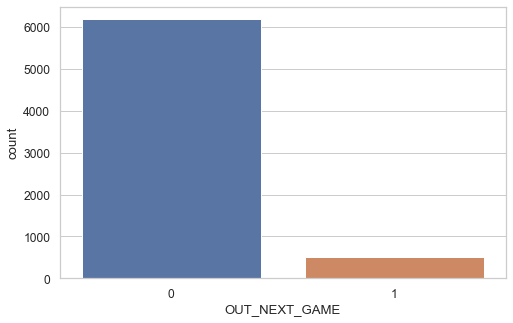

In [1245]:
# counts - OUT_NEXT_GAME (0,1)
sns.set(style='whitegrid', font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.countplot(x='OUT_NEXT_GAME', data=game_logs_subset_X_df_copy)

num_rows = game_logs_subset_X_df_copy.shape[0]

tot_ong = full_game_logs_df['OUT_NEXT_GAME'].sum()
tot_ong_other = num_rows - tot_ong
pct_ong = (tot_ong/num_rows) * 100
pct_ong_other = 100 - pct_ong
print('Num OUT_NEXT_GAME (0): %d, %% of sample: %.2f%%' %(tot_ong_other, pct_ong_other))
print('Num OUT_NEXT_GAME (1): %d, %% of sample: %.2f%%' %(tot_ong, pct_ong))


In [1246]:
# oversample the training data to have even distribution of OUT_NEXT_GAME 0,1
oversample = SMOTE()
X_train,Y_train=oversample.fit_resample(X_train,Y_train)

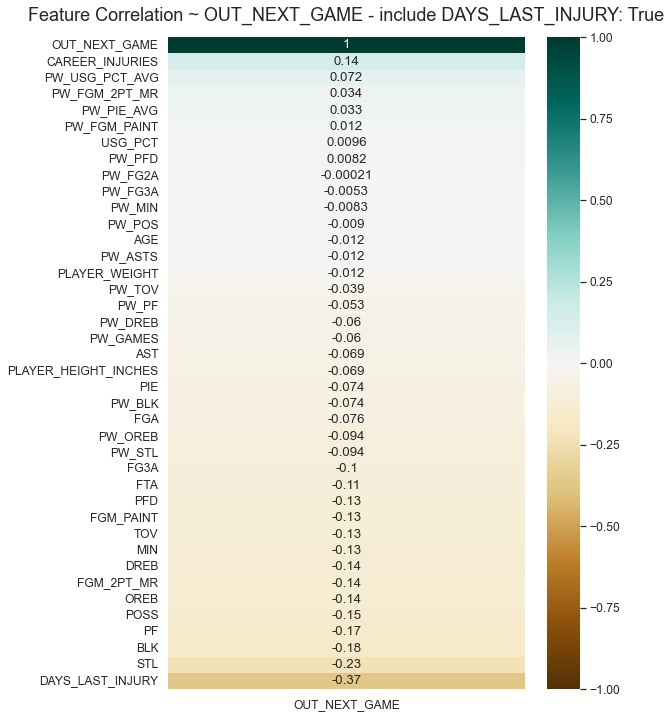

In [1247]:
# create OUT_NEXT_GAME correlation chart (after oversampling)
X_train_copy = X_train.copy()
X_train_copy.loc[:,'OUT_NEXT_GAME'] = Y_train
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(X_train_copy.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', 
    ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature Correlation ~ OUT_NEXT_GAME - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY), fontdict={'fontsize':18}, pad=16);

In [1248]:
# counts - OUT_NEXT_GAME (0,1)
# sns.set(style='whitegrid', font_scale=1.1, rc={"figure.figsize": [8, 5]})
# sns.countplot(x='OUT_NEXT_GAME', data=X_train_copy)

# tot_ong = Y_train.sum()
# pct_ong = tot_ong/len(Y_train)*100
# print('Num OUT_NEXT_GAME: %d, %% of sample: %.2f%%' %(tot_ong, pct_ong))

In [1295]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# simple logistic regression
model = LogisticRegression(random_state=42, max_iter=10000).fit(X_train_scaled, Y_train)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

Accuracy: 93.0 %
Precision: 53.0 %
Recall: 91.0 %
F1 score: 67.0 %
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1239
           1       0.53      0.91      0.67       101

    accuracy                           0.93      1340
   macro avg       0.76      0.92      0.82      1340
weighted avg       0.96      0.93      0.94      1340



Text(0.5, 1.0, 'Logistic Regression ~ OUT_NEXT_GAME - Coefficients - include DAYS_LAST_INJURY: True')

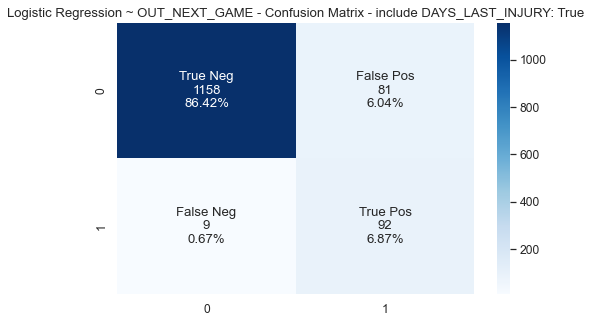

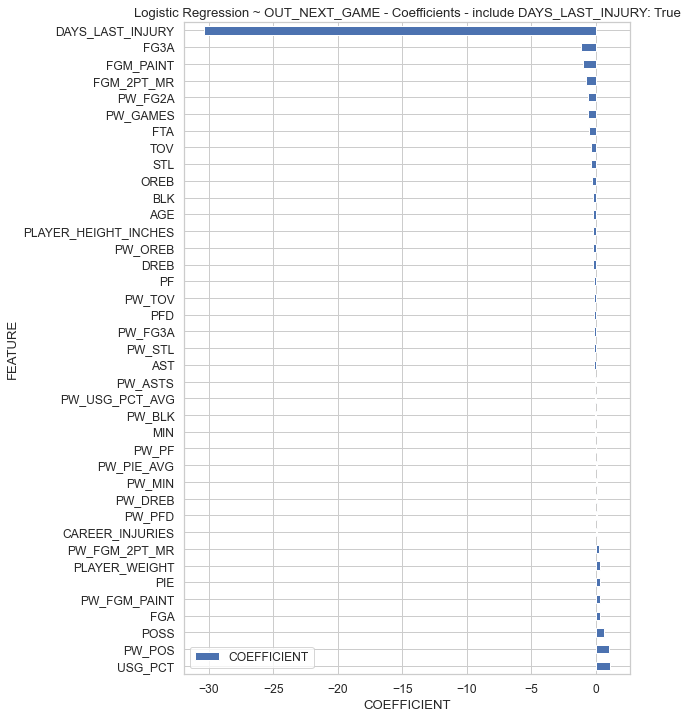

In [1296]:
# logistic regression - model analytics and results
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

# Print the results
print('Accuracy:', round(accuracy,2) * 100,'%')
print('Precision:', round(precision,2) * 100,'%')
print('Recall:', round(recall,2) * 100,'%')
print('F1 score:', round(f1,2) * 100,'%')

# Print classification report
report = classification_report(Y_test, y_pred)
print(report)

# confusion matrix
cm = confusion_matrix(Y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
    cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax)
ax.set_title('Logistic Regression ~ OUT_NEXT_GAME - Confusion Matrix - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY))

# Plot coefficients
model_coefs = pd.DataFrame({'FEATURE': game_logs_subset_X_df.columns.tolist(), 
    'COEFFICIENT':model.coef_[0].tolist()})
model_coefs = model_coefs.sort_values(by='COEFFICIENT', ascending=False)

coef_plot = model_coefs.plot(x='FEATURE', y='COEFFICIENT', kind='barh', figsize=(8, 12))
coef_plot.set_xlabel('COEFFICIENT')
coef_plot.set_title('Logistic Regression ~ OUT_NEXT_GAME - Coefficients - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY))

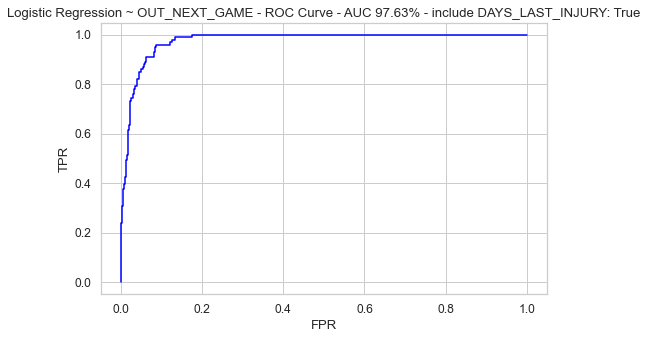

In [1251]:
# create ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
roc_auc = round(auc(fpr,tpr)*100,2)

plt.plot(fpr,tpr, color="blue")
plt.title('Logistic Regression ~ OUT_NEXT_GAME - ROC Curve - AUC ' + str(roc_auc) + '% - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [1178]:
# RUNNING HOT ENGINE PROTOTYPE - uses logistic regression model - WORK-IN-PROGRESS
def running_hot_engine(game_data, model, running_hot_threshold=50):
    # prep, transform, scale game log for model
    game_data_subset_X_df, game_data_subset_Y = prep_data(game_data)
    game_data_scaled = scaler.transform(game_data_subset_X_df)

    # get running hot probability via model
    running_hot_proba = model.predict_proba(game_data_scaled)[:, 1]

    # interpret probability via threshold
    running_hot_idx_results = []
    running_hot_results = []
    for proba in running_hot_proba:
        proba_100 = proba * 100
        running_hot_idx = round((proba_100),1)
        running_hot = False
        if (running_hot_idx > running_hot_threshold):
            running_hot = True
        running_hot_idx_results.append(running_hot_idx)
        running_hot_results.append(running_hot)

    # return results as dataframe
    running_hot_df = pd.DataFrame()
    running_hot_df.loc[:,'PLAYER_NAME']  = game_data['PLAYER_NAME'].values.tolist()
    running_hot_df.loc[:,'GAME_DATE']  = game_data['GAME_DATE'].values.tolist()
    running_hot_df.loc[:,'RUNNING_HOT_IDX']  = running_hot_idx_results
    running_hot_df.loc[:,'RUNNING_HOT']  = running_hot_results
    running_hot_df.loc[:,'OUT_NEXT_GAME']  = game_data_subset_Y.values.tolist()
    
    return running_hot_df

In [1179]:
# basic analytics on running hot results
def basic_running_hot_analytics(running_hot_df):
    running_hot_results_int = [int(running_hot) for running_hot in running_hot_df['RUNNING_HOT']]
    out_next_game_list = luka_game_data['OUT_NEXT_GAME'].values.tolist()
    match = []
    for i in range(len(running_hot_results_int)):
        this_match = (running_hot_results_int[i] == out_next_game_list[i])
        match.append(this_match)
    number_match = sum(bool(x) for x in match)
    match_pct = round((number_match/running_hot_df.shape[0]) * 100,2)

    run_hot_sit_next_count = 0
    run_hot_play_next_count = 0
    not_run_hot_sit_next_count = 0
    not_run_hot_play_next_count = 0
    for i in range(len(running_hot_results_int)):
        if (running_hot_results_int[i] == 1) & (out_next_game_list[i] == 1): # run_hot_sit_next_count
            run_hot_sit_next_count += 1
        elif (running_hot_results_int[i] == 1) & (out_next_game_list[i] == 0): # run_hot_play_next_count
            run_hot_play_next_count += 1
        elif (running_hot_results_int[i] == 0) & (out_next_game_list[i] == 1): # not_run_hot_sit_next_count
            not_run_hot_sit_next_count += 1
        elif (running_hot_results_int[i] == 0) & (out_next_game_list[i] == 0): # not_run_hot_play_next_count
            not_run_hot_play_next_count += 1

    # output results
    print('TOTAL GAME LOGS: ' + str(running_hot_df.shape[0]))
    print('TOTAL RUNNING HOT IN GAME LOGS: ' + str(sum(running_hot_results_int)))
    print('RUNNING_HOT/OUT_NEXT_GAME MATCH PERCENTAGE: ' + str(match_pct) + '%')
    print('TIMES SAT OUT NEXT GAME WHILE ABOVE RUNNING HOT THRESHOLD (' + 
      str(RUNNING_HOT_THRESHOLD)+ ') (RECOMMENDED BY MODEL): ' + str(run_hot_sit_next_count))
    print('TIMES PLAYED NEXT GAME WHILE UNDER RUNNING HOT THRESHOLD (' + 
      str(RUNNING_HOT_THRESHOLD)+ ') (RECOMMENDED BY MODEL): ' + str(not_run_hot_play_next_count))
    print('TIMES PLAYED NEXT GAME WHILE ABOVE RUNNING HOT THRESHOLD (' + 
      str(RUNNING_HOT_THRESHOLD)+ ') (*NOT* RECOMMENDED BY MODEL): ' + str(run_hot_play_next_count))
    print('TIMES SAT NEXT GAME WHILE UNDER RUNNING HOT THRESHOLD (' + 
      str(RUNNING_HOT_THRESHOLD)+ ') (*NOT* RECOMMENDED BY MODEL): ' + str(not_run_hot_sit_next_count))

In [1180]:
# running hot engine settings - set threshold at 50 (default 50)
RUNNING_HOT_THRESHOLD = 50

In [1276]:
# get sample game log: Luka Doncic (PLAYER_ID = 1629029), DAL @ SAS 2022-04-10 (GAME_ID = 22101209)
luka_game_data = full_game_logs_df.loc[(full_game_logs_df['PLAYER_ID']==1629029)&(full_game_logs_df['GAME_ID']==22101219)]
luka_game_data.T

,20
SEASON_YEAR,2021-22
PLAYER_ID,1629029
PLAYER_NAME,Luka Doncic
TEAM_ID,1610612742
TEAM_ABBREVIATION,DAL
TEAM_NAME,Dallas Mavericks
GAME_ID,22101219
GAME_DATE,2022-04-10T00:00:00
MATCHUP,DAL vs. SAS
WL,W


In [1275]:
luka_game_data.to_csv('luka_single_game_log.csv')

In [1273]:
# feed game data into running hot engine
running_hot_df = running_hot_engine(luka_game_data, model, RUNNING_HOT_THRESHOLD)
print(running_hot_df)

# run basic analytics on running hot results
basic_running_hot_analytics(running_hot_df)

# output to .csv file
running_hot_df.to_csv('running_hot_luka_single_game.csv')

   PLAYER_NAME            GAME_DATE  RUNNING_HOT_IDX  RUNNING_HOT  \
0  Luka Doncic  2022-04-08T00:00:00              8.7        False   

   OUT_NEXT_GAME  
0              0  
TOTAL GAME LOGS: 1
TOTAL RUNNING HOT IN GAME LOGS: 0
RUNNING_HOT/OUT_NEXT_GAME MATCH PERCENTAGE: 100.0%
TIMES SAT OUT NEXT GAME WHILE ABOVE RUNNING HOT THRESHOLD (50) (RECOMMENDED BY MODEL): 0
TIMES PLAYED NEXT GAME WHILE UNDER RUNNING HOT THRESHOLD (50) (RECOMMENDED BY MODEL): 1
TIMES PLAYED NEXT GAME WHILE ABOVE RUNNING HOT THRESHOLD (50) (*NOT* RECOMMENDED BY MODEL): 0
TIMES SAT NEXT GAME WHILE UNDER RUNNING HOT THRESHOLD (50) (*NOT* RECOMMENDED BY MODEL): 0


In [1274]:
running_hot_df.T

,0
PLAYER_NAME,Luka Doncic
GAME_DATE,2022-04-08T00:00:00
RUNNING_HOT_IDX,8.7
RUNNING_HOT,False
OUT_NEXT_GAME,0


In [1259]:
# get all of Luka Doncic's regular season game logs from 2021-22
luka_game_data = full_game_logs_df.loc[(full_game_logs_df['PLAYER_ID']==1629029)]
luka_game_data

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
20,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22101219,2022-04-10T00:00:00,DAL vs. SAS,W,...,210,6,24,15.0,2.0,0.216667,0.431333,26,20,0
78,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22101209,2022-04-08T00:00:00,DAL vs. POR,W,...,222,9,23,14.0,5.0,0.160333,0.417000,26,18,0
134,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22101190,2022-04-06T00:00:00,DAL @ DET,W,...,229,6,19,19.0,5.0,0.192000,0.390333,26,16,0
247,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22101167,2022-04-03T00:00:00,DAL @ MIL,W,...,270,8,25,27.0,6.0,0.220000,0.390000,26,13,0
323,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22101152,2022-04-01T00:00:00,DAL @ WAS,L,...,270,5,24,24.0,5.0,0.229750,0.358500,26,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6240,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22100075,2021-10-29T00:00:00,DAL @ DEN,L,...,220,9,16,20.0,6.0,0.168667,0.356000,20,183,0
6280,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22100069,2021-10-28T00:00:00,DAL vs. SAS,W,...,228,7,19,14.0,8.0,0.179667,0.329667,20,182,0
6388,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22100052,2021-10-26T00:00:00,DAL vs. HOU,W,...,153,4,12,9.0,4.0,0.154500,0.318000,20,180,0
6515,2021-22,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,22100029,2021-10-23T00:00:00,DAL @ TOR,W,...,77,1,6,2.0,2.0,0.136000,0.276000,20,177,0


In [1260]:
luka_game_data.to_csv('luka_game_logs_2021-22.csv')

In [1261]:
# feed game data into running hot engine
running_hot_df = running_hot_engine(luka_game_data, model, RUNNING_HOT_THRESHOLD)
print(running_hot_df)

# run basic analytics on running hot results
basic_running_hot_analytics(running_hot_df)

# output to .csv file
running_hot_df.to_csv('running_hot_luka_2021-22.csv')

    PLAYER_NAME            GAME_DATE  RUNNING_HOT_IDX  RUNNING_HOT  \
0   Luka Doncic  2022-04-10T00:00:00              9.0        False   
1   Luka Doncic  2022-04-08T00:00:00              8.7        False   
2   Luka Doncic  2022-04-06T00:00:00              3.3        False   
3   Luka Doncic  2022-04-03T00:00:00             12.2        False   
4   Luka Doncic  2022-04-01T00:00:00             33.5        False   
..          ...                  ...              ...          ...   
60  Luka Doncic  2021-10-29T00:00:00              0.0        False   
61  Luka Doncic  2021-10-28T00:00:00              0.0        False   
62  Luka Doncic  2021-10-26T00:00:00              0.0        False   
63  Luka Doncic  2021-10-23T00:00:00              0.0        False   
64  Luka Doncic  2021-10-21T00:00:00              0.0        False   

    OUT_NEXT_GAME  
0               0  
1               0  
2               0  
3               0  
4               0  
..            ...  
60              0  

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
AUC: 1.0
Confusion matrix:
[[1239    0]
 [   0  101]]


Text(0.5, 1.0, 'Random Forest ~ OUT_NEXT_GAME - Confusion Matrix - include DAYS_LAST_INJURY: True')

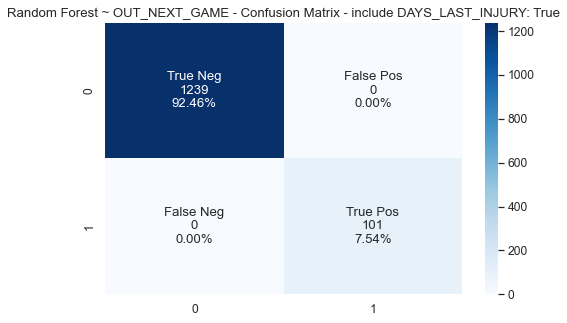

In [1288]:
# simple random forest - TBD
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

acc = accuracy_score(Y_test, y_pred)
prec = precision_score(Y_test, y_pred, average='weighted')
rec = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')
auc = roc_auc_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)

# Print the results
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)
print('AUC:', auc)
print('Confusion matrix:')
print(cm)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
    cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax)
ax.set_title('Random Forest ~ OUT_NEXT_GAME - Confusion Matrix - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY))

Accuracy: 0.9246268656716418
Precision: 0.8549348407217644
Recall: 0.9246268656716418
F1 score: 0.8884161974154045
AUC: 0.5
Confusion matrix:
[[1239    0]
 [ 101    0]]


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\Reed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Random Forest ~ OUT_NEXT_GAME - Confusion Matrix - include DAYS_LAST_INJURY: True')

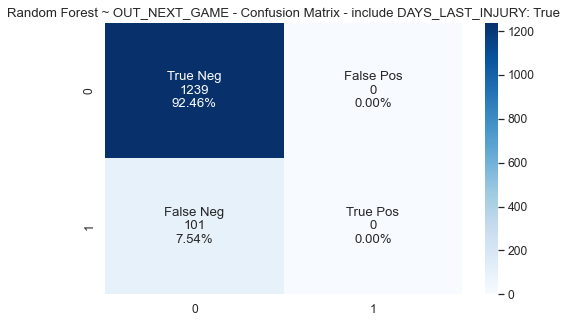

In [1298]:
# SVM: TBD
svc = SVC(kernel='linear', gamma=0.01, C=2, probability=True)
svc.fit(X_train_scaled,Y_train)

y_pred_proba = svc.predict_proba(X_test_scaled)
y_pred = svc.predict(X_test)

acc = accuracy_score(Y_test, y_pred)
prec = precision_score(Y_test, y_pred, average='weighted')
rec = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')
auc = roc_auc_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)

# Print the results
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)
print('AUC:', auc)
print('Confusion matrix:')
print(cm)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
    cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax)
ax.set_title('Random Forest ~ OUT_NEXT_GAME - Confusion Matrix - include DAYS_LAST_INJURY: ' + 
    str(not REMOVE_DAYS_LAST_INJURY))